In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('/content/merged_dataset_1.csv')
df.head()

,tweet,new_sentiment
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [37]:
df.tail(20)

,tweet,new_sentiment
3305363,All these puts printing \n\n$spy $nugt $jpm $c...,1.0
3305364,RT @CarterBWorth: The mkt's been at current le...,1.0
3305365,RT @MacroCharts: Amazon $AMZN.\n\nFOMO traders...,1.0
3305366,RT @MarketRealist: Facebook Ad Boycott: Zucker...,1.0
3305367,If you are new to stock markets and want to in...,1.0
3305368,Brokers Offer Predictions for National-Oilwell...,1.0
3305369,RT @MarkNewtonCMT: $IHI Ishares Medical Dvcs E...,1.0
3305370,$CODX latest news from FDA is a game changer!\...,1.0
3305371,We're still looking for someone else who can b...,1.0
3305372,Zacks: Analysts Anticipate Ulta Beauty Inc $UL...,1.0


DATA PREPROCESSING


In [38]:
# Checking for Null values
df.isnull().sum()

,0
tweet,4
new_sentiment,7


In [45]:
# Dropping the null values
# Dropping the null values
df.dropna(inplace=True)


In [46]:
# Checking for Null values
df.isnull().sum()

,0
tweet,0
new_sentiment,0


In [47]:




# Checking for Duplicates
df.duplicated().sum()

855275

In [48]:
# Function to normalize tweet text
def normalize_tweet(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply normalization to tweets
df["tweet"] = df["tweet"].apply(normalize_tweet)

# Assuming your sentiment column is named 'new_sentiment' or something similar
# Replace 'new_sentiment' with the actual column name if different
sentiment_column_name = df.columns[1]  # Get the name of the second column (index 1)


# Handle NaN values in the sentiment column
# Option 1: Fill NaN with a default value, e.g., -1 (you can choose any value)
df[sentiment_column_name] = df[sentiment_column_name].fillna(-1).astype(int)

# Option 2: Alternatively, if you want to drop rows with NaN sentiment values
# df = df.dropna(subset=[sentiment_column_name])

# Save the cleaned dataset
df.to_csv("twitter_dataset_cleaned.csv", index=False)

print("Data normalization complete. Cleaned file saved as 'twitter_dataset_cleaned.csv'.")

Data normalization complete. Cleaned file saved as 'twitter_dataset_cleaned.csv'.


In [49]:
df.head(20)

,tweet,new_sentiment
0,when modi promised minimum government maximum ...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp to...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
5,kiya tho refresh maarkefir comment karo,0
6,surat women perform yagna seeks divine grace f...,0
7,this comes from cabinet which has scholars lik...,0
8,with upcoming election india saga going import...,1
9,gandhi was gay does modi,1


In [50]:
df.tail(20)

,tweet,new_sentiment
3305363,all these puts printing spy nugt jpm cvna,1
3305364,rt the mkts been at current levels for 3 wks n...,1
3305365,rt amazon amzn fomo traders bidding up skews t...,1
3305366,rt facebook ad boycott zuckerberg and dorsey m...,1
3305367,if you are new to stock markets and want to in...,1
3305368,brokers offer predictions for nationaloilwell ...,1
3305369,rt ihi ishares medical dvcs etf broke back out...,1
3305370,codx latest news from fda is a game changer in...,1
3305371,were still looking for someone else who can be...,1
3305372,zacks analysts anticipate ulta beauty inc ulta...,1


In [51]:
# Let's get a word count
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split(" "))) # Changed 'text' to 'tweet'

# Number of Characters (including spaces)
df['char_count'] = df['tweet'].str.len() # Changed 'text' to 'tweet'

# Average Word Length
# Average Word Length
def avg_word(sentence):
    words = sentence.split()
    if words:  # Check if the words list is not empty
        return (sum(len(word) for word in words) / len(words))
    else:
        return 0  # Return 0 for empty sentences

df['avg_word'] = df['tweet'].apply(lambda x: avg_word(x)) # Changed 'text' to 'tweet'

df['avg_word'] = df['tweet'].apply(lambda x: avg_word(x)) # Changed 'text' to 'tweet'

# Number of Stop Words
nltk.download('stopwords')
stop = stopwords.words('english')

df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop])) # Changed 'text' to 'tweet'
# Number of hashtags
df['hastags'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('@')])) # Changed 'text' to 'tweet'

# Number of numerics
df['numerics'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()])) # Changed 'text' to 'tweet'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
df.head()

,tweet,new_sentiment,word_count,char_count,avg_word,stopwords,hastags,numerics
0,when modi promised minimum government maximum ...,-1,33,208,5.333333,12,0,0
1,talk all the nonsense and continue all the dra...,0,13,67,4.230769,7,0,0
2,what did just say vote for modi welcome bjp to...,1,22,116,4.318182,9,0,0
3,asking his supporters prefix chowkidar their n...,1,34,212,5.264706,15,0,0
4,answer who among these the most powerful world...,1,14,80,4.785714,4,0,0


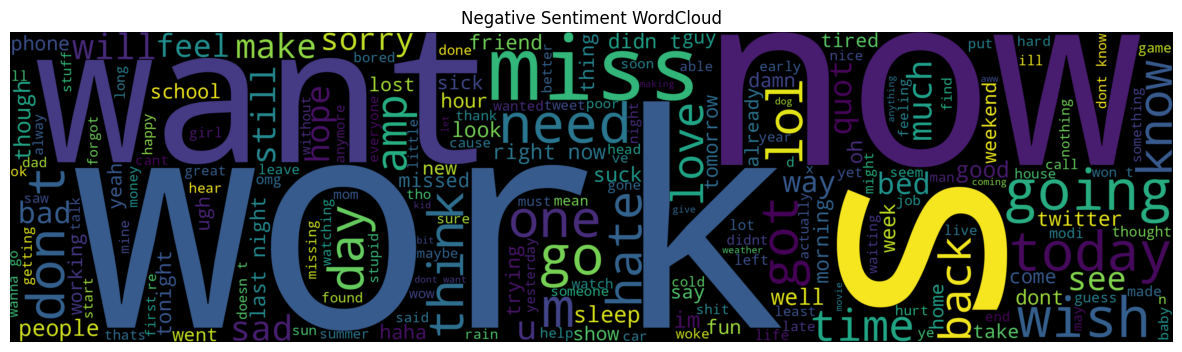

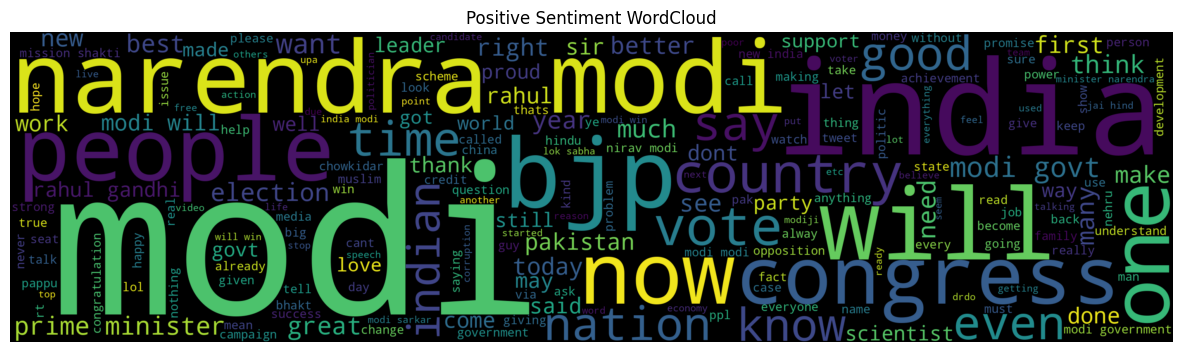

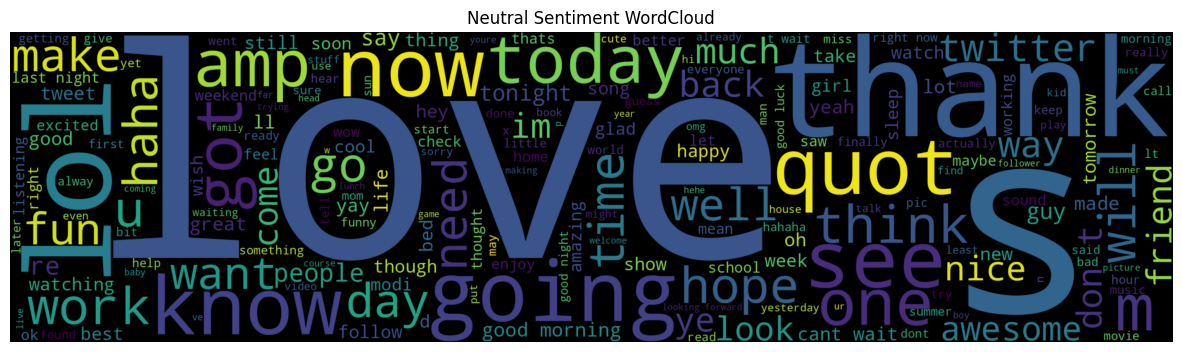

In [55]:
# Install WordCloud
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# Assuming your sentiment column is named 'new_sentiment'
# Replace 'new_sentiment' with the actual column name if different
sentiment_column_name = 'new_sentiment'

# Split the dataframe by sentiment
negative_df = df[df[sentiment_column_name] == -1]
positive_df = df[df[sentiment_column_name] == 1]
neutral_df = df[df[sentiment_column_name] == 0]


# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['tweet'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

In [56]:
# Removal of stop words
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df.head()

,tweet,new_sentiment,word_count,char_count,avg_word,stopwords,hastags,numerics
0,modi promised minimum government maximum gover...,-1,33,208,5.333333,12,0,0
1,talk nonsense continue drama vote modi,0,13,67,4.230769,7,0,0
2,say vote modi welcome bjp told rahul main camp...,1,22,116,4.318182,9,0,0
3,asking supporters prefix chowkidar names modi ...,1,34,212,5.264706,15,0,0
4,answer among powerful world leader today trump...,1,14,80,4.785714,4,0,0


In [57]:
# Rare Words Removal
freq = pd.Series(' '.join(df['tweet']).split()).value_counts()[:30]
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Rare words frequency
freq = pd.Series(' '.join(df['tweet']).split()).value_counts()[-10:]
freq

# Stemming
st = PorterStemmer()
df['tweet'] = df['tweet'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df.head()

,tweet,new_sentiment,word_count,char_count,avg_word,stopwords,hastags,numerics
0,promis minimum govern maximum govern expect be...,-1,33,208,5.333333,12,0,0
1,talk nonsens continu drama vote,0,13,67,4.230769,7,0,0
2,say vote welcom bjp told rahul main campaign r...,1,22,116,4.318182,9,0,0
3,ask support prefix chowkidar name great servic...,1,34,212,5.264706,15,0,0
4,answer among power world leader trump putin may,1,14,80,4.785714,4,0,0


In [62]:
print(df['new_sentiment'].value_counts())

new_sentiment
 0    1616822
-1    1605576
 1      82974
Name: count, dtype: int64


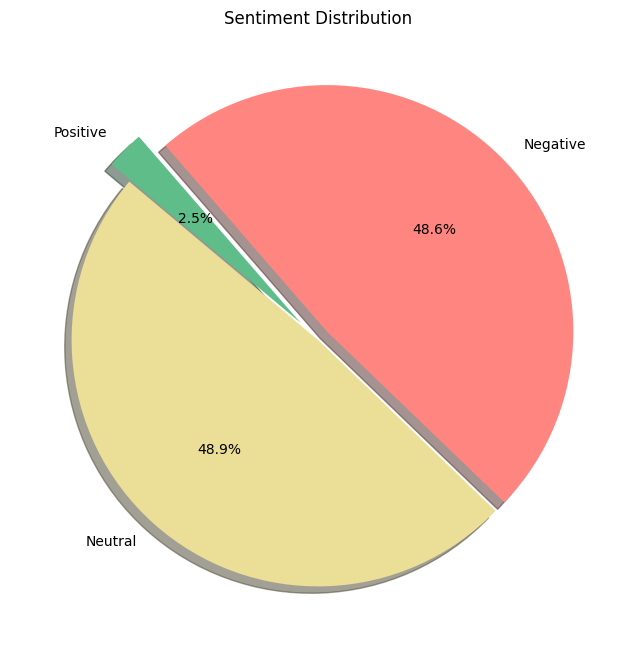

In [63]:
import matplotlib.pyplot as plt

# Sentiment counts
sentiment_counts = [1616822, 1605576, 82974]  # Manually setting values
labels = ['Neutral', 'Negative', 'Positive']  # Correct order of labels
colors = ['#ebde96', '#ff8680', '#5ebd89']  # Matching colors correctly

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', colors=colors,
        explode=[0, 0.05, 0.1], shadow=True, startangle=140)
plt.title("Sentiment Distribution")
plt.show()


In [ ]:
import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Define stopwords manually (same as before)
stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
              "you", "your", "yours", "yourself", "yourselves", "he", "him", "his",
              "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which",
              "who", "whom", "this", "that", "these", "those", "am", "is", "are",
              "was", "were", "be", "been", "being", "have", "has", "had", "having",
              "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if",
              "or", "because", "as", "until", "while", "of", "at", "by", "for",
              "with", "about", "against", "between", "into", "through", "during",
              "before", "after", "above", "below", "to", "from", "up", "down",
              "in", "out", "on", "off", "over", "under", "again", "further",
              "then", "once", "here", "there", "when", "where", "why", "how",
              "all", "any", "both", "each", "few", "more", "most", "other", "some",
              "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should",
              "now"}

# Preprocessing function
def preprocess_text(text):
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words and token.is_alpha]
    return " ".join(tokens)

# Apply preprocessing
df['processed_tweet'] = df['tweet'].apply(preprocess_text)

# Display results
print(df[['tweet', 'processed_tweet', 'new_sentiment']].head())